In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [16]:
import numpy as np
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time

np.random.seed(42)

class ActivationFunction:
    @staticmethod
    def linear(x: np.ndarray) -> np.ndarray:
        return x
    
    @staticmethod
    def linear_derivative(x: np.ndarray) -> np.ndarray:
        return np.ones_like(x)
    
    @staticmethod
    def relu(x: np.ndarray) -> np.ndarray:
        return np.maximum(0, x)
    
    @staticmethod
    def relu_derivative(x: np.ndarray) -> np.ndarray:
        return (x > 0).astype(float)
    
    @staticmethod
    def sigmoid(x: np.ndarray) -> np.ndarray:
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def sigmoid_derivative(x: np.ndarray) -> np.ndarray:
        sig = ActivationFunction.sigmoid(x)
        return sig * (1 - sig)
    
    @staticmethod
    def tanh(x: np.ndarray) -> np.ndarray:
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x: np.ndarray) -> np.ndarray:
        return 1 - np.tanh(x) ** 2
    
    @staticmethod
    def softmax(x: np.ndarray) -> np.ndarray:
        x_shifted = x - np.max(x, axis=1, keepdims=True)
        e_x = np.exp(x_shifted)
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    @staticmethod
    def softmax_derivative(x: np.ndarray) -> np.ndarray:
        s = ActivationFunction.softmax(x)
        return s * (1 - s)

class LossFunction:
    @staticmethod
    def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return np.mean((y_true - y_pred) ** 2)
    
    @staticmethod
    def mse_derivative(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return -2 * (y_true - y_pred) / y_true.shape[0]

    @staticmethod
    def bce(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true*np.log(y_pred)+(1-y_true)*np.log(1-y_pred))

    @staticmethod
    def bce_derivative(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return (y_pred - y_true) / (y_pred * (1 - y_pred) * y_true.shape[0])

    @staticmethod
    def cce(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    
    @staticmethod
    def cce_derivative(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -(y_true / y_pred) / y_true.shape[0]

class CustomFFNN:
    def __init__(self, layer_sizes, activations, loss='mse', weight_method='normal', regularization=None, lambda_=0.01):
        """
        Initialize a feed-forward neural network with fully connected layers.
        
        Args:
            layer_sizes: List of integers representing number of neurons in each layer
            activations: List of activation functions for each layer
            loss: Loss function to use
            weight_method: Method for weight initialization
        """
        self.layer_sizes = layer_sizes
        self.activations = activations
        self.loss = loss
        self.N_layer = len(layer_sizes)
        self.regularization=regularization
        self.lambda_ = lambda_
        self.weights = []
        self.biases = []
        self.outputs = [] 
        self.z_values = []
        self.weight_gradients = []
        self.bias_gradients = []
        self.neuron_gradients = []

        for i in range(len(layer_sizes) - 1):
            if weight_method == 'zero':
                w = np.zeros((layer_sizes[i], layer_sizes[i+1]))
            elif weight_method == 'uniform':
                w = np.random.uniform(-0.1, 0.1, (layer_sizes[i], layer_sizes[i+1]))
            elif weight_method == 'normal':
                if activations[i] == 'relu':
                    scale = np.sqrt(2.0 / layer_sizes[i])
                else:
                    scale = np.sqrt(1.0 / layer_sizes[i])
                w = np.random.normal(0, scale, (layer_sizes[i], layer_sizes[i+1]))
            else:
                raise ValueError(f"Unknown initialization method: {weight_method}")
                
            b = np.zeros(layer_sizes[i+1])
            
            self.weights.append(w)
            self.biases.append(b)
            
            self.weight_gradients.append(np.zeros_like(w))
            self.bias_gradients.append(np.zeros_like(b))
            
        self.outputs = [np.zeros(size) for size in layer_sizes]
        self.z_values = [np.zeros(size) for size in layer_sizes[1:]]
        self.neuron_gradients = [np.zeros(size) for size in layer_sizes]
        
            
    
    def _activate(self, x, activation):
        """Apply activation function to input"""
        if activation == 'linear':
            return ActivationFunction.linear(x)
        elif activation == 'relu':
            return ActivationFunction.relu(x)
        elif activation == 'sigmoid':
            return ActivationFunction.sigmoid(x)
        elif activation == 'tanh':
            return ActivationFunction.tanh(x)
        elif activation == 'softmax':
            return ActivationFunction.softmax(x)
        else:
            raise ValueError(f"Unknown activation function: {activation}")
    
    def _activate_derivative(self, x, activation):
        """Apply derivative of activation function"""
        if activation == 'linear':
            return ActivationFunction.linear_derivative(x)
        elif activation == 'relu':
            return ActivationFunction.relu_derivative(x)
        elif activation == 'sigmoid':
            return ActivationFunction.sigmoid_derivative(x)
        elif activation == 'tanh':
            return ActivationFunction.tanh_derivative(x)
        elif activation == 'softmax':
            return ActivationFunction.softmax_derivative(x)
        else:
            raise ValueError(f"Unknown activation function: {activation}")
        
    def _regularization_loss(self):
        """Calculate regularization loss"""
        if self.regularization is None:
            return 0.0
        reg_loss = 0.0
        for w in self.weights:
            if self.regularization == 'L2':
                reg_loss += np.sum(w ** 2)
            elif self.regularization == 'L1':
                reg_loss += np.sum(np.abs(w))

        return self.lambda_ * reg_loss
    
    def _regularization_gradient(self, weight_matrix):
        """Calculate regularization gradient"""
        if self.regularization is None:
            return 0.0
        if self.regularization == 'L1':
            return self.lambda_ * np.sign(weight_matrix)
        elif self.regularization == 'L2':
            return self.lambda_ * weight_matrix * 2
        return 0.0
    
    def forward(self, X):
        """Forward pass through the network"""
        self.outputs[0] = X
        
        # Forward through each layer
        for i in range(self.N_layer - 1):
            # z = x·W + b
            z = np.dot(self.outputs[i], self.weights[i]) + self.biases[i]
            self.z_values[i] = z
            
            # Apply activation
            self.outputs[i+1] = self._activate(z, self.activations[i])
        
        return self.outputs[-1]
    
    def backward(self, X, y, learning_rate):
        """Backward pass through the network"""
        batch_size = X.shape[0]
        
        y_pred = self.forward(X)

        if self.loss == 'mse':
            d_loss = y_pred - y 
        elif self.loss == 'cce':
            if self.activations[-1] == 'softmax':
                d_loss = y_pred - y
            else:
                d_loss = LossFunction.cce_derivative(y, y_pred)
        elif self.loss == 'bce':
            if self.activations[-1] == 'sigmoid':
                d_loss = y_pred - y
            else:
                d_loss = LossFunction.bce_derivative(y, y_pred)
        else:
            raise ValueError(f"Unsupported loss function: {self.loss}")
        
        delta = d_loss
        # Store gradient for output layer
        self.neuron_gradients[-1] = delta.mean(axis=0)
        
        for i in range(self.N_layer - 2, -1, -1):
            if i < self.N_layer - 2 or not ((self.loss == 'cce' and self.activations[-1] == 'softmax') or 
                                        (self.loss == 'bce' and self.activations[-1] == 'sigmoid')):
                delta = delta * self._activate_derivative(self.z_values[i], self.activations[i])
            
            # Calculate gradients
            dW = np.dot(self.outputs[i].T, delta) / batch_size
            db = np.mean(delta, axis=0)
            
            # Store gradients
            self.weight_gradients[i] = dW
            self.bias_gradients[i] = db
            
            # Regularization
            if self.regularization:
                reg_grad = self._regularization_gradient(self.weights[i])
                dW += reg_grad / batch_size
            #Update
            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db
            
            # Propagate error to previous layer
            if i > 0:
                delta = np.dot(delta, self.weights[i].T)
                self.neuron_gradients[i] = np.mean(delta, axis=0)

        if len(self.layer_sizes) > 2:
            self.neuron_gradients[0] = np.mean(delta, axis=0)
    
    def fit(self, X, y, epochs=10, learning_rate=0.01, batch_size=32, verbose=True, track_loss=True):
        """
        Train the neural network
        """
        n_samples = X.shape[0]
        loss_history = [] if track_loss else None
        
        for epoch in range(1, epochs + 1):
            start_time = time.time()
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            if verbose:
                batch_range = tqdm(range(0, n_samples, batch_size),
                                desc=f"Epoch {epoch}",
                                leave=False,
                                unit="batch")
            else:
                batch_range = range(0, n_samples, batch_size)

            for i in batch_range:
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                self.backward(X_batch, y_batch, learning_rate)

            if verbose or track_loss:
                y_pred = self.forward(X)
                
                if self.loss == 'mse':
                    loss = LossFunction.mse(y, y_pred)
                elif self.loss == 'cce':
                    loss = LossFunction.cce(y, y_pred)
                elif self.loss == 'bce':
                    loss = LossFunction.bce(y, y_pred)

                # Regularization loss
                if self.regularization:
                    reg_loss = self._regularization_loss()
                    total_loss = loss + reg_loss
                    if track_loss:
                        loss_history.append(total_loss)
                    if verbose:
                        print(f"\nEpoch {epoch}, Loss: {loss:.4f}, Reg Loss: {reg_loss:.4f}, "
                              f"Total: {total_loss:.4f}, Time: {time.time() - start_time:.2f}s")
                else:
                    if track_loss:
                        loss_history.append(loss)
                    if verbose:
                        print(f"\nEpoch {epoch}, Loss: {loss:.4f}, Time: {time.time() - start_time:.2f}s")
        
        return loss_history
    
    def predict(self, X):
        """Make predictions for input data"""
        return self.forward(X)
    
    def save(self, filename):
        """Save model to file"""
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
    
    @staticmethod
    def load(filename):
        """Load model from file"""
        with open(filename, 'rb') as f:
            return pickle.load(f)
            
    def visualize_network(self, show_weights=True, show_gradients=True):
        """Network visualization with weights and gradients"""
        G = nx.DiGraph()

        node_positions = {}
        node_count = 0
        
        for layer_idx, size in enumerate(self.layer_sizes):
            for neuron_idx in range(size):
                node_id = f"L{layer_idx}_N{neuron_idx}"
                gradient = self.neuron_gradients[layer_idx][neuron_idx] if layer_idx < len(self.neuron_gradients) else 0
                G.add_node(node_id, layer=layer_idx, gradient=gradient)
                node_positions[node_id] = (layer_idx, -neuron_idx + size/2)
                node_count += 1

        for layer_idx in range(len(self.layer_sizes) - 1):
            for i in range(self.layer_sizes[layer_idx]):
                for j in range(self.layer_sizes[layer_idx + 1]):
                    from_node = f"L{layer_idx}_N{i}"
                    to_node = f"L{layer_idx+1}_N{j}"
                    weight = self.weights[layer_idx][i, j]
                    weight_gradient = self.weight_gradients[layer_idx][i, j]
                    G.add_edge(from_node, to_node, weight=weight, gradient=weight_gradient)
        
        # Plot
        plt.figure(figsize=(10, 8))
        
        # Color nodes based on gradient
        if show_gradients and any(np.any(g != 0) for g in self.neuron_gradients):
            # Get all gradients flattened for normalization
            all_gradients = [abs(g) for layer_grads in self.neuron_gradients for g in layer_grads]
            max_grad = max(all_gradients) if all_gradients else 1.0
            
            # Create color map for nodes
            node_colors = []
            for node in G.nodes():
                gradient = abs(G.nodes[node].get('gradient', 0))
                intensity = min(gradient / max_grad, 1.0) if max_grad > 0 else 0
                # Use a heat map: white (small gradient) to red (large gradient)
                node_colors.append((1.0, 1.0-intensity, 1.0-intensity))
        else:
            node_colors = ['skyblue'] * len(G.nodes())
        
        nx.draw_networkx_nodes(G, node_positions, node_size=500, node_color=node_colors)

        if show_weights:
            max_weight = max(abs(w) for _, _, w in G.edges.data('weight'))
            max_grad = max(abs(g) for _, _, g in G.edges.data('gradient')) if show_gradients else 1.0
            
            for u, v, d in G.edges(data=True):
                weight = d['weight']
                width = 1 + 3 * abs(weight) / max_weight
                
                # Color based on weight sign and gradient magnitude if showing gradients
                if show_gradients and max_grad > 0:
                    gradient = abs(d.get('gradient', 0))
                    intensity = min(gradient / max_grad, 1.0) if max_grad > 0 else 0
                    # Base color on weight sign, intensity on gradient
                    color = 'darkred' if weight < 0 else 'darkgreen'
                    # Make edges more transparent for small gradients
                    alpha = 0.2 + 0.8 * intensity
                else:
                    color = 'red' if weight < 0 else 'green'
                    alpha = 1.0
                    
                nx.draw_networkx_edges(G, node_positions, edgelist=[(u, v)], 
                                    width=width, edge_color=color, arrows=True, alpha=alpha)
        else:
            nx.draw_networkx_edges(G, node_positions, arrows=True)
            
        nx.draw_networkx_labels(G, node_positions)
        
        # Add legend
        if show_gradients:
            plt.figtext(0.01, 0.01, "Node color: white (small gradient) to red (large gradient)", fontsize=9)
            plt.figtext(0.01, 0.03, "Edge opacity: transparent (small gradient) to solid (large gradient)", fontsize=9)
        
        plt.title("Neural Network Architecture with Gradients")
        plt.axis('off')
        plt.show()

    def visualize_selected_layers(self, layers_to_show, show_weights=True, show_gradients=True):
        """
        Visualize only selected layers of the network with gradient information
        """
        G = nx.DiGraph()

        node_positions = {}
        for layer_idx in layers_to_show:
            if layer_idx >= len(self.layer_sizes):
                print(f"Warning: Layer {layer_idx} does not exist in the network")
                continue
                
            size = self.layer_sizes[layer_idx]
            for neuron_idx in range(size):
                node_id = f"L{layer_idx}_N{neuron_idx}"
                gradient = self.neuron_gradients[layer_idx][neuron_idx] if layer_idx < len(self.neuron_gradients) else 0
                G.add_node(node_id, layer=layer_idx, gradient=gradient)
                node_positions[node_id] = (layer_idx, -neuron_idx + size/2)

        for i in range(len(layers_to_show) - 1):
            current_layer = layers_to_show[i]
            next_layer = layers_to_show[i + 1]

            if next_layer - current_layer == 1:
                for ni in range(self.layer_sizes[current_layer]):
                    for nj in range(self.layer_sizes[next_layer]):
                        from_node = f"L{current_layer}_N{ni}"
                        to_node = f"L{next_layer}_N{nj}"
                        weight = self.weights[current_layer][ni, nj]
                        weight_gradient = self.weight_gradients[current_layer][ni, nj]
                        G.add_edge(from_node, to_node, weight=weight, gradient=weight_gradient)

        plt.figure(figsize=(12, 8))
        
        # Color nodes based on gradient
        if show_gradients and any(np.any(g != 0) for g in self.neuron_gradients):
            # Get all gradients for selected layers
            selected_gradients = []
            for layer_idx in layers_to_show:
                if layer_idx < len(self.neuron_gradients):
                    selected_gradients.extend([abs(g) for g in self.neuron_gradients[layer_idx]])
            
            max_grad = max(selected_gradients) if selected_gradients else 1.0
            
            # Create color map for nodes
            node_colors = []
            for node in G.nodes():
                gradient = abs(G.nodes[node].get('gradient', 0))
                intensity = min(gradient / max_grad, 1.0) if max_grad > 0 else 0
                # Use a heat map: white (small gradient) to red (large gradient)
                node_colors.append((1.0, 1.0-intensity, 1.0-intensity))
        else:
            node_colors = ['skyblue'] * len(G.nodes())
        
        nx.draw_networkx_nodes(G, node_positions, node_size=500, node_color=node_colors)

        if show_weights and G.edges:
            max_weight = max(abs(w) for _, _, w in G.edges.data('weight'))
            max_grad = max(abs(g) for _, _, g in G.edges.data('gradient')) if show_gradients else 1.0
            
            for u, v, d in G.edges(data=True):
                weight = d['weight']
                width = 1 + 3 * abs(weight) / max_weight
                
                # Color based on weight sign and gradient magnitude if showing gradients
                if show_gradients and max_grad > 0:
                    gradient = abs(d.get('gradient', 0))
                    intensity = min(gradient / max_grad, 1.0) if max_grad > 0 else 0
                    # Base color on weight sign, intensity on gradient
                    color = 'darkred' if weight < 0 else 'darkgreen'
                    # Make edges more transparent for small gradients
                    alpha = 0.2 + 0.8 * intensity
                else:
                    color = 'red' if weight < 0 else 'green'
                    alpha = 1.0
                    
                nx.draw_networkx_edges(G, node_positions, edgelist=[(u, v)], 
                                    width=width, edge_color=color, arrows=True, alpha=alpha)

                if show_weights:
                    label = f"{weight:.2f}"
                    if show_gradients:
                        label += f" (g:{d.get('gradient', 0):.2e})"
                    edge_label = {(u, v): label}
                    nx.draw_networkx_edge_labels(G, node_positions, edge_labels=edge_label, 
                                            font_size=8, label_pos=0.3)
        else:
            nx.draw_networkx_edges(G, node_positions, arrows=True)

        # Add node labels with gradients
        node_labels = {}
        for node in G.nodes():
            gradient = G.nodes[node].get('gradient', 0)
            label = node
            if show_gradients:
                label += f"\ng:{gradient:.2e}"
            node_labels[node] = label
        
        nx.draw_networkx_labels(G, node_positions, labels=node_labels)

        for layer_idx in layers_to_show:
            if layer_idx < len(self.layer_sizes):
                plt.text(layer_idx, self.layer_sizes[layer_idx]/2 + 1, 
                        f"Layer {layer_idx}\n({self.activations[layer_idx] if layer_idx < len(self.activations) else 'input'})", 
                        ha='center')
        
        # Add legend
        if show_gradients:
            plt.figtext(0.01, 0.01, "Node color: white (small gradient) to red (large gradient)", fontsize=9)
            plt.figtext(0.01, 0.03, "Edge opacity: transparent (small gradient) to solid (large gradient)", fontsize=9)
        
        plt.title(f"Neural Network Architecture (Selected Layers: {sorted(layers_to_show)}) with Gradients")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    def plot_loss(self, loss_history, title="Training Loss", figsize=(10, 6)):
        """
        Plot the loss history
        """
        plt.figure(figsize=figsize)
        plt.plot(loss_history, 'b-')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def save_to_txt(self, filename):
        """
        Save the neural network parameters and gradients to a text file.
        
        Args:
            filename (str): Path to the output text file
        """
        with open(filename, 'w') as f:
            f.write("Feed-Forward Neural Network Configuration\n")
            f.write("=======================================\n\n")
            
            # architecture
            f.write(f"Architecture: {self.layer_sizes}\n")
            f.write(f"Activation functions: {self.activations}\n")
            f.write(f"Loss function: {self.loss}\n")
            f.write(f"Regularization: {self.regularization}, lambda={self.lambda_}\n\n")
            
            # Write neuron gradients for input layer
            f.write(f"Input Layer (Layer 0) Gradients:\n")
            f.write("-" * 40 + "\n")
            for i, grad in enumerate(self.neuron_gradients[0]):
                f.write(f"  Neuron {i}: {grad:.6e}\n")
            f.write("\n")
            
            # Write weights, biases and gradients for each layer
            for i in range(len(self.weights)):
                from_layer = i
                to_layer = i + 1
                
                f.write(f"Layer {from_layer} -> Layer {to_layer}\n")
                f.write("-" * 40 + "\n")
                
                # Write weights and weight gradients
                f.write(f"Weights (shape: {self.weights[i].shape}):\n")
                f.write(f"  From Layer {from_layer} neurons to Layer {to_layer} neurons:\n")
                for row_idx, row in enumerate(self.weights[i]):
                    w_row = ' '.join([f'{w:.6f}' for w in row])
                    g_row = ' '.join([f'{g:.6e}' for g in self.weight_gradients[i][row_idx]])
                    f.write(f"  Neuron {row_idx} -> {w_row}\n")
                    f.write(f"    Gradients -> {g_row}\n")
                

                f.write(f"\nBiases for Layer {to_layer} neurons:\n")
                b_vals = ' '.join([f'{b:.6f}' for b in self.biases[i]])
                g_vals = ' '.join([f'{g:.6e}' for g in self.bias_gradients[i]])
                f.write(f"  Values: {b_vals}\n")
                f.write(f"  Gradients: {g_vals}\n")
                
                f.write(f"\nNeuron Gradients for Layer {to_layer}:\n")
                for j, grad in enumerate(self.neuron_gradients[to_layer]):
                    f.write(f"  Neuron {j}: {grad:.6e}\n")
                f.write("\n")



In [17]:
# Load dataset
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')
X, y = mnist.data, mnist.target

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Scale pixel values to [0, 1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [19]:
# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.reshape(-1, 1))

In [20]:
results = {}
training_loss_history_per_width = {}
validation_loss_history_per_width = {}

In [21]:
# Variasi WIDTH (depth tetap = 3 layer)
width_variations = [[784, 10, 10], [784, 64, 10], [784, 128, 10]]
activation_width = [['relu', 'softmax']] * 3

In [22]:
epochs = 10
for i, width in enumerate(width_variations):
    model = CustomFFNN(
        layer_sizes=width,
        activations = activation_width[i],
        loss='cce', # Use 'cce' for multi-class classification
        weight_method='normal'
    )
    print(f"\nTraining model with width: {width}")
    training_losses = model.fit(X_train, y_train_encoded, epochs=epochs, learning_rate=0.01, batch_size=32)
    validation_losses = []

    for i in range(1, epochs+1):
        # Calculate validation loss
        start_time = time.time()
        y_val_pred_encoded = model.predict(X_val)
        if model.loss == 'mse':
            val_loss = LossFunction.mse(y_val_encoded, y_val_pred_encoded)
        elif model.loss == 'cce':
            val_loss = LossFunction.cce(y_val_encoded, y_val_pred_encoded)
        elif model.loss == 'bce':
            val_loss = LossFunction.bce(y_val_encoded, y_val_pred_encoded)
        else:
            val_loss = np.nan
        validation_losses.append(val_loss)
    
        if True: # verbose
            print(f"\nEpoch {i}, Training Loss: {training_losses[i-1]:.4f}, Validation Loss: {val_loss:.4f}, time: {time.time()-start_time}")
    

    y_pred_encoded = model.predict(X_val)
    y_pred = np.argmax(y_pred_encoded, axis=1)
    y_val_true = np.argmax(y_val_encoded, axis=1)
    acc = accuracy_score(y_val_true, y_pred)

    results[f'Width {width[1]}'] = acc
    training_loss_history_per_width[f'Width {width[1]}'] = training_losses
    validation_loss_history_per_width[f'Width {width[1]}'] = validation_losses

    print(f"\nValidation Accuracy (Width {width[1]}): {acc:.4f}")
    model.save_to_txt(f"width_variations_{width[1]}")




Training model with width: [784, 10, 10]



Epoch 1, Loss: 0.5296, Time: 0.58s



Epoch 2, Loss: 0.4217, Time: 0.59s



Epoch 3, Loss: 0.3716, Time: 0.58s



Epoch 4, Loss: 0.3390, Time: 0.58s



Epoch 5, Loss: 0.3188, Time: 0.66s



Epoch 6, Loss: 0.3064, Time: 0.58s



Epoch 7, Loss: 0.2983, Time: 0.59s



Epoch 8, Loss: 0.2925, Time: 0.58s



Epoch 9, Loss: 0.2845, Time: 0.60s



Epoch 10, Loss: 0.2802, Time: 0.59s

Epoch 1, Training Loss: 0.5296, Validation Loss: 0.2963, time: 0.011171340942382812

Epoch 2, Training Loss: 0.4217, Validation Loss: 0.2963, time: 0.01017451286315918

Epoch 3, Training Loss: 0.3716, Validation Loss: 0.2963, time: 0.010190486907958984

Epoch 4, Training Loss: 0.3390, Validation Loss: 0.2963, time: 0.009957075119018555

Epoch 5, Training Loss: 0.3188, Validation Loss: 0.2963, time: 0.009854793548583984

Epoch 6, Training Loss: 0.3064, Validation Loss: 0.2963, time: 0.009887933731079102

Epoch 7, Training Loss: 0.2983, Validation Loss: 0.2963, time: 0.010309696197509766

Epoch 8, Training Loss: 0.2925, Validation Loss: 0.2963, time: 0.010085344314575195

Epoch 9, Training Loss: 0.2845, Validation Loss: 0.2963, time: 0.01056051254272461

Epoch 10, Training Loss: 0.2802, Validation Loss: 0.2963, time: 0.01038217544555664

Validation Accuracy (Width 10): 0.9200

Training model with width: [784, 64, 10]



Epoch 1, Loss: 0.4115, Time: 1.15s



Epoch 2, Loss: 0.3373, Time: 1.15s



Epoch 3, Loss: 0.2990, Time: 1.16s



Epoch 4, Loss: 0.2738, Time: 1.16s



Epoch 5, Loss: 0.2535, Time: 1.20s



Epoch 6, Loss: 0.2361, Time: 1.24s



Epoch 7, Loss: 0.2214, Time: 1.17s



Epoch 8, Loss: 0.2107, Time: 1.17s



Epoch 9, Loss: 0.1992, Time: 1.50s



Epoch 10, Loss: 0.1881, Time: 1.48s

Epoch 1, Training Loss: 0.4115, Validation Loss: 0.2089, time: 0.028512001037597656

Epoch 2, Training Loss: 0.3373, Validation Loss: 0.2089, time: 0.02772974967956543

Epoch 3, Training Loss: 0.2990, Validation Loss: 0.2089, time: 0.027716398239135742

Epoch 4, Training Loss: 0.2738, Validation Loss: 0.2089, time: 0.029003620147705078

Epoch 5, Training Loss: 0.2535, Validation Loss: 0.2089, time: 0.027654647827148438

Epoch 6, Training Loss: 0.2361, Validation Loss: 0.2089, time: 0.02851700782775879

Epoch 7, Training Loss: 0.2214, Validation Loss: 0.2089, time: 0.026849031448364258

Epoch 8, Training Loss: 0.2107, Validation Loss: 0.2089, time: 0.02895665168762207

Epoch 9, Training Loss: 0.1992, Validation Loss: 0.2089, time: 0.027643203735351562

Epoch 10, Training Loss: 0.1881, Validation Loss: 0.2089, time: 0.028847932815551758

Validation Accuracy (Width 64): 0.9431

Training model with width: [784, 128, 10]



Epoch 1, Loss: 0.4053, Time: 1.79s



Epoch 2, Loss: 0.3283, Time: 1.81s



Epoch 3, Loss: 0.2938, Time: 1.84s



Epoch 4, Loss: 0.2650, Time: 1.82s



Epoch 5, Loss: 0.2441, Time: 1.78s



Epoch 6, Loss: 0.2287, Time: 1.79s



Epoch 7, Loss: 0.2127, Time: 1.82s



Epoch 8, Loss: 0.1979, Time: 1.84s



Epoch 9, Loss: 0.1869, Time: 1.82s



Epoch 10, Loss: 0.1757, Time: 1.91s

Epoch 1, Training Loss: 0.4053, Validation Loss: 0.1974, time: 0.0476527214050293

Epoch 2, Training Loss: 0.3283, Validation Loss: 0.1974, time: 0.04931354522705078

Epoch 3, Training Loss: 0.2938, Validation Loss: 0.1974, time: 0.04805183410644531

Epoch 4, Training Loss: 0.2650, Validation Loss: 0.1974, time: 0.047029972076416016

Epoch 5, Training Loss: 0.2441, Validation Loss: 0.1974, time: 0.04807114601135254

Epoch 6, Training Loss: 0.2287, Validation Loss: 0.1974, time: 0.0472869873046875

Epoch 7, Training Loss: 0.2127, Validation Loss: 0.1974, time: 0.0469660758972168

Epoch 8, Training Loss: 0.1979, Validation Loss: 0.1974, time: 0.046460866928100586

Epoch 9, Training Loss: 0.1869, Validation Loss: 0.1974, time: 0.0472874641418457

Epoch 10, Training Loss: 0.1757, Validation Loss: 0.1974, time: 0.04666471481323242

Validation Accuracy (Width 128): 0.9462


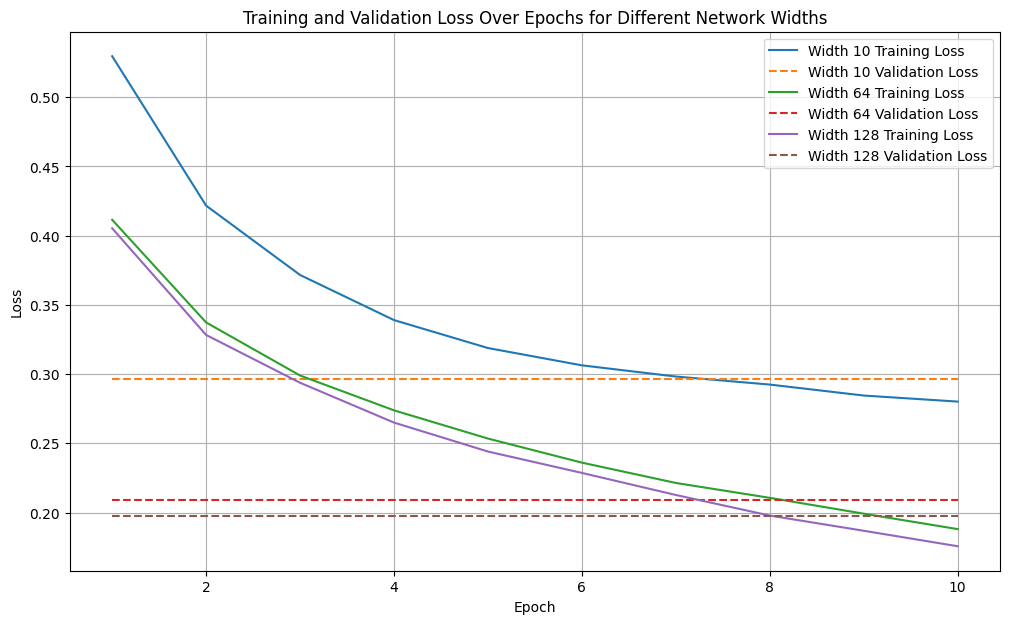


Validation Accuracies:
Width 10: 0.9200
Width 64: 0.9431
Width 128: 0.9462


In [23]:
# Plotting the loss history
plt.figure(figsize=(12, 7))
for width_label, train_history in training_loss_history_per_width.items():
    val_history = validation_loss_history_per_width[width_label]
    epochs = range(1, len(train_history) + 1)
    plt.plot(epochs, train_history, label=f'{width_label} Training Loss')
    plt.plot(epochs, val_history, label=f'{width_label} Validation Loss', linestyle='--')

plt.title('Training and Validation Loss Over Epochs for Different Network Widths')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nValidation Accuracies:")
for width, accuracy in results.items():
    print(f"{width}: {accuracy:.4f}")

In [24]:
results = {}
training_loss_history_per_depth = {}
validation_loss_history_per_depth = {}

In [25]:
# Variasi DEPTH (jumlah hidden layer bervariasi)
depth_variations = [
    [784, 64, 10],              
    [784, 64, 64, 10],          
    [784, 64, 64, 64, 10]       
]
activation_depth = [
    ['relu', 'softmax'],       
    ['relu', 'relu', 'softmax'],  
    ['relu', 'relu', 'sigmoid', 'softmax']  
]

In [26]:
epochs = 10
for i, layer_sizes in enumerate(depth_variations):
    model = CustomFFNN(
        layer_sizes=layer_sizes,
        activations=activation_depth[i],
        loss='cce',
        weight_method='normal'
    )
    
    label = f"Depth {len(layer_sizes) - 2}"  # subtract input and output layer
    print(f"\nTraining model with {label}: {layer_sizes}")

    training_losses = model.fit(X_train, y_train_encoded, epochs=epochs, learning_rate=0.01, batch_size=32)
    validation_losses = []

    for ep in range(1, epochs + 1):
        start_time = time.time()
        y_val_pred_encoded = model.predict(X_val)
        if model.loss == 'mse':
            val_loss = LossFunction.mse(y_val_encoded, y_val_pred_encoded)
        elif model.loss == 'cce':
            val_loss = LossFunction.cce(y_val_encoded, y_val_pred_encoded)
        elif model.loss == 'bce':
            val_loss = LossFunction.bce(y_val_encoded, y_val_pred_encoded)
        else:
            val_loss = np.nan
        validation_losses.append(val_loss)

        if True:
            print(f"Epoch {ep}, Training Loss: {training_losses[ep-1]:.4f}, Validation Loss: {val_loss:.4f}, Time: {time.time()-start_time:.2f}s")

    y_pred_encoded = model.predict(X_val)
    y_pred = np.argmax(y_pred_encoded, axis=1)
    y_val_true = np.argmax(y_val_encoded, axis=1)
    acc = accuracy_score(y_val_true, y_pred)

    results[label] = acc
    training_loss_history_per_depth[label] = training_losses
    validation_loss_history_per_depth[label] = validation_losses

    print(f"\nValidation Accuracy ({label}): {acc:.4f}")
    model.save_to_txt(f"depth_variations_{label}")
    


Training model with Depth 1: [784, 64, 10]



Epoch 1, Loss: 0.4139, Time: 1.20s



Epoch 2, Loss: 0.3319, Time: 1.21s



Epoch 3, Loss: 0.2984, Time: 1.19s



Epoch 4, Loss: 0.2745, Time: 1.22s



Epoch 5, Loss: 0.2570, Time: 1.21s



Epoch 6, Loss: 0.2423, Time: 1.17s



Epoch 7, Loss: 0.2286, Time: 1.19s



Epoch 8, Loss: 0.2151, Time: 1.22s



Epoch 9, Loss: 0.2059, Time: 1.37s



Epoch 10, Loss: 0.1960, Time: 1.21s
Epoch 1, Training Loss: 0.4139, Validation Loss: 0.2160, Time: 0.03s
Epoch 2, Training Loss: 0.3319, Validation Loss: 0.2160, Time: 0.03s
Epoch 3, Training Loss: 0.2984, Validation Loss: 0.2160, Time: 0.03s
Epoch 4, Training Loss: 0.2745, Validation Loss: 0.2160, Time: 0.03s
Epoch 5, Training Loss: 0.2570, Validation Loss: 0.2160, Time: 0.03s
Epoch 6, Training Loss: 0.2423, Validation Loss: 0.2160, Time: 0.03s
Epoch 7, Training Loss: 0.2286, Validation Loss: 0.2160, Time: 0.03s
Epoch 8, Training Loss: 0.2151, Validation Loss: 0.2160, Time: 0.03s
Epoch 9, Training Loss: 0.2059, Validation Loss: 0.2160, Time: 0.03s
Epoch 10, Training Loss: 0.1960, Validation Loss: 0.2160, Time: 0.03s

Validation Accuracy (Depth 1): 0.9405

Training model with Depth 2: [784, 64, 64, 10]



Epoch 1, Loss: 0.3390, Time: 1.41s



Epoch 2, Loss: 0.2759, Time: 1.48s



Epoch 3, Loss: 0.2377, Time: 1.47s



Epoch 4, Loss: 0.2024, Time: 1.48s



Epoch 5, Loss: 0.1827, Time: 1.44s



Epoch 6, Loss: 0.1688, Time: 1.46s



Epoch 7, Loss: 0.1679, Time: 1.48s



Epoch 8, Loss: 0.1427, Time: 1.45s



Epoch 9, Loss: 0.1363, Time: 1.51s



Epoch 10, Loss: 0.1394, Time: 1.46s
Epoch 1, Training Loss: 0.3390, Validation Loss: 0.1736, Time: 0.04s
Epoch 2, Training Loss: 0.2759, Validation Loss: 0.1736, Time: 0.04s
Epoch 3, Training Loss: 0.2377, Validation Loss: 0.1736, Time: 0.04s
Epoch 4, Training Loss: 0.2024, Validation Loss: 0.1736, Time: 0.04s
Epoch 5, Training Loss: 0.1827, Validation Loss: 0.1736, Time: 0.04s
Epoch 6, Training Loss: 0.1688, Validation Loss: 0.1736, Time: 0.03s
Epoch 7, Training Loss: 0.1679, Validation Loss: 0.1736, Time: 0.04s
Epoch 8, Training Loss: 0.1427, Validation Loss: 0.1736, Time: 0.04s
Epoch 9, Training Loss: 0.1363, Validation Loss: 0.1736, Time: 0.04s
Epoch 10, Training Loss: 0.1394, Validation Loss: 0.1736, Time: 0.04s

Validation Accuracy (Depth 2): 0.9509

Training model with Depth 3: [784, 64, 64, 64, 10]



Epoch 1, Loss: 0.8684, Time: 1.89s



Epoch 2, Loss: 0.4538, Time: 1.86s



Epoch 3, Loss: 0.3537, Time: 1.88s



Epoch 4, Loss: 0.3052, Time: 1.96s



Epoch 5, Loss: 0.2706, Time: 1.86s



Epoch 6, Loss: 0.2467, Time: 1.88s



Epoch 7, Loss: 0.2246, Time: 1.90s



Epoch 8, Loss: 0.2071, Time: 2.31s



Epoch 9, Loss: 0.1900, Time: 1.93s



Epoch 10, Loss: 0.1756, Time: 1.88s
Epoch 1, Training Loss: 0.8684, Validation Loss: 0.1936, Time: 0.04s
Epoch 2, Training Loss: 0.4538, Validation Loss: 0.1936, Time: 0.04s
Epoch 3, Training Loss: 0.3537, Validation Loss: 0.1936, Time: 0.04s
Epoch 4, Training Loss: 0.3052, Validation Loss: 0.1936, Time: 0.04s
Epoch 5, Training Loss: 0.2706, Validation Loss: 0.1936, Time: 0.04s
Epoch 6, Training Loss: 0.2467, Validation Loss: 0.1936, Time: 0.04s
Epoch 7, Training Loss: 0.2246, Validation Loss: 0.1936, Time: 0.04s
Epoch 8, Training Loss: 0.2071, Validation Loss: 0.1936, Time: 0.04s
Epoch 9, Training Loss: 0.1900, Validation Loss: 0.1936, Time: 0.04s
Epoch 10, Training Loss: 0.1756, Validation Loss: 0.1936, Time: 0.04s

Validation Accuracy (Depth 3): 0.9451


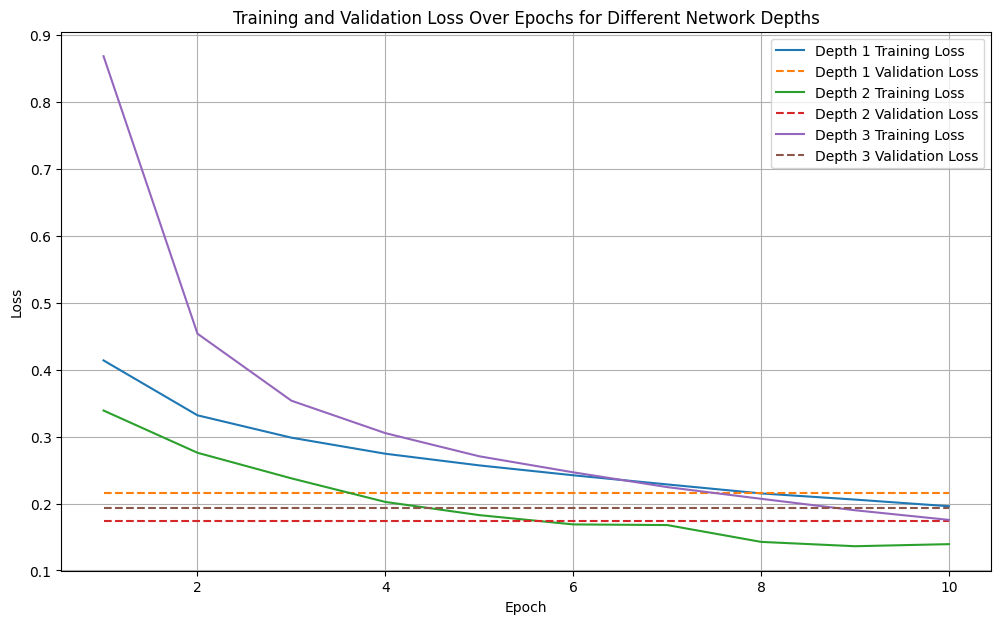


Validation Accuracies:
Depth 1: 0.9405
Depth 2: 0.9509
Depth 3: 0.9451


In [27]:
# Plotting the loss history for different depths
plt.figure(figsize=(12, 7))
for depth_label, train_history in training_loss_history_per_depth.items():
    val_history = validation_loss_history_per_depth[depth_label]
    epochs = range(1, len(train_history) + 1)
    plt.plot(epochs, train_history, label=f'{depth_label} Training Loss')
    plt.plot(epochs, val_history, label=f'{depth_label} Validation Loss', linestyle='--')

plt.title('Training and Validation Loss Over Epochs for Different Network Depths')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nValidation Accuracies:")
for depth, accuracy in results.items():
    print(f"{depth}: {accuracy:.4f}")


In [28]:
# Activation Variations
activation_functions = [
    ['relu', 'relu', 'softmax'],
    ['linear', 'linear', 'softmax'],
    ['tanh', 'tanh', 'softmax'],
    ['sigmoid', 'sigmoid', 'softmax']
]
results = {}
training_loss_history_per_activations = {}
validation_loss_history_per_activations = {}

In [36]:
epochs = 10
layer_sizes = [784, 128, 64, 10]

for i, activations in enumerate(activation_functions):
    model = CustomFFNN(
        layer_sizes=layer_sizes,
        activations=activations,
        loss='cce',
        weight_method='normal'
    )

    label = f"Activation {activations[0]}-{activations[1]}"
    print(f"\nTraining model with {label}: {layer_sizes}")

    training_losses = model.fit(X_train, y_train_encoded, epochs=epochs, learning_rate=0.01, batch_size=32)
    validation_losses = []

    for ep in range(1, epochs + 1):
        start_time = time.time()
        y_val_pred_encoded = model.predict(X_val)

        if model.loss == 'mse':
            val_loss = LossFunction.mse(y_val_encoded, y_val_pred_encoded)
        elif model.loss == 'cce':
            val_loss = LossFunction.cce(y_val_encoded, y_val_pred_encoded)
        elif model.loss == 'bce':
            val_loss = LossFunction.bce(y_val_encoded, y_val_pred_encoded)
        else:
            val_loss = np.nan
        validation_losses.append(val_loss)

        print(f"Epoch {ep}, Training Loss: {training_losses[ep-1]:.4f}, Validation Loss: {val_loss:.4f}, Time: {time.time()-start_time:.2f}s")

    # Akurasi
    y_pred_encoded = model.predict(X_val)
    y_pred = np.argmax(y_pred_encoded, axis=1)
    y_val_true = np.argmax(y_val_encoded, axis=1)
    acc = accuracy_score(y_val_true, y_pred)

    # Simpan hasil
    results[label] = acc
    training_loss_history_per_activations[label] = training_losses
    validation_loss_history_per_activations[label] = validation_losses

    print(f"\nValidation Accuracy ({label}): {acc:.4f}")
    model.save_to_txt(f"activations_variations_{label}")
    


Training model with Activation relu-relu: [784, 128, 64, 10]



Epoch 1, Loss: 0.3474, Time: 2.21s



Epoch 2, Loss: 0.2699, Time: 2.12s



Epoch 3, Loss: 0.2296, Time: 2.13s



Epoch 4, Loss: 0.2040, Time: 2.09s



Epoch 5, Loss: 0.1817, Time: 2.10s



Epoch 6, Loss: 0.1617, Time: 2.11s



Epoch 7, Loss: 0.1587, Time: 2.10s



Epoch 8, Loss: 0.1443, Time: 2.11s



Epoch 9, Loss: 0.1300, Time: 2.16s



Epoch 10, Loss: 0.1170, Time: 2.24s
Epoch 1, Training Loss: 0.3474, Validation Loss: 0.1501, Time: 0.06s
Epoch 2, Training Loss: 0.2699, Validation Loss: 0.1501, Time: 0.06s
Epoch 3, Training Loss: 0.2296, Validation Loss: 0.1501, Time: 0.06s
Epoch 4, Training Loss: 0.2040, Validation Loss: 0.1501, Time: 0.06s
Epoch 5, Training Loss: 0.1817, Validation Loss: 0.1501, Time: 0.05s
Epoch 6, Training Loss: 0.1617, Validation Loss: 0.1501, Time: 0.06s
Epoch 7, Training Loss: 0.1587, Validation Loss: 0.1501, Time: 0.06s
Epoch 8, Training Loss: 0.1443, Validation Loss: 0.1501, Time: 0.06s
Epoch 9, Training Loss: 0.1300, Validation Loss: 0.1501, Time: 0.06s
Epoch 10, Training Loss: 0.1170, Validation Loss: 0.1501, Time: 0.06s

Validation Accuracy (Activation relu-relu): 0.9569

Training model with Activation linear-linear: [784, 128, 64, 10]



Epoch 1, Loss: 0.3570, Time: 1.94s



Epoch 2, Loss: 0.3158, Time: 1.96s



Epoch 3, Loss: 0.2972, Time: 1.99s



Epoch 4, Loss: 0.2867, Time: 2.32s



Epoch 5, Loss: 0.2872, Time: 2.09s



Epoch 6, Loss: 0.2730, Time: 1.94s



Epoch 7, Loss: 0.2701, Time: 1.93s



Epoch 8, Loss: 0.2681, Time: 1.93s



Epoch 9, Loss: 0.2642, Time: 1.92s



Epoch 10, Loss: 0.2634, Time: 1.96s
Epoch 1, Training Loss: 0.3570, Validation Loss: 0.2916, Time: 0.04s
Epoch 2, Training Loss: 0.3158, Validation Loss: 0.2916, Time: 0.04s
Epoch 3, Training Loss: 0.2972, Validation Loss: 0.2916, Time: 0.04s
Epoch 4, Training Loss: 0.2867, Validation Loss: 0.2916, Time: 0.04s
Epoch 5, Training Loss: 0.2872, Validation Loss: 0.2916, Time: 0.04s
Epoch 6, Training Loss: 0.2730, Validation Loss: 0.2916, Time: 0.04s
Epoch 7, Training Loss: 0.2701, Validation Loss: 0.2916, Time: 0.04s
Epoch 8, Training Loss: 0.2681, Validation Loss: 0.2916, Time: 0.04s
Epoch 9, Training Loss: 0.2642, Validation Loss: 0.2916, Time: 0.04s
Epoch 10, Training Loss: 0.2634, Validation Loss: 0.2916, Time: 0.04s

Validation Accuracy (Activation linear-linear): 0.9197

Training model with Activation tanh-tanh: [784, 128, 64, 10]



Epoch 1, Loss: 0.3887, Time: 2.25s



Epoch 2, Loss: 0.3079, Time: 2.21s



Epoch 3, Loss: 0.2719, Time: 2.29s



Epoch 4, Loss: 0.2444, Time: 2.25s



Epoch 5, Loss: 0.2236, Time: 2.23s



Epoch 6, Loss: 0.2055, Time: 2.25s



Epoch 7, Loss: 0.1888, Time: 2.20s



Epoch 8, Loss: 0.1777, Time: 2.26s



Epoch 9, Loss: 0.1632, Time: 2.56s



Epoch 10, Loss: 0.1527, Time: 2.23s
Epoch 1, Training Loss: 0.3887, Validation Loss: 0.1751, Time: 0.04s
Epoch 2, Training Loss: 0.3079, Validation Loss: 0.1751, Time: 0.04s
Epoch 3, Training Loss: 0.2719, Validation Loss: 0.1751, Time: 0.05s
Epoch 4, Training Loss: 0.2444, Validation Loss: 0.1751, Time: 0.05s
Epoch 5, Training Loss: 0.2236, Validation Loss: 0.1751, Time: 0.05s
Epoch 6, Training Loss: 0.2055, Validation Loss: 0.1751, Time: 0.05s
Epoch 7, Training Loss: 0.1888, Validation Loss: 0.1751, Time: 0.05s
Epoch 8, Training Loss: 0.1777, Validation Loss: 0.1751, Time: 0.04s
Epoch 9, Training Loss: 0.1632, Validation Loss: 0.1751, Time: 0.04s
Epoch 10, Training Loss: 0.1527, Validation Loss: 0.1751, Time: 0.05s

Validation Accuracy (Activation tanh-tanh): 0.9493

Training model with Activation sigmoid-sigmoid: [784, 128, 64, 10]



Epoch 1, Loss: 2.1663, Time: 2.46s



Epoch 2, Loss: 1.7119, Time: 2.59s



Epoch 3, Loss: 1.2130, Time: 2.46s



Epoch 4, Loss: 0.9144, Time: 2.52s



Epoch 5, Loss: 0.7381, Time: 2.47s



Epoch 6, Loss: 0.6270, Time: 2.53s



Epoch 7, Loss: 0.5498, Time: 2.51s



Epoch 8, Loss: 0.4941, Time: 2.47s



Epoch 9, Loss: 0.4527, Time: 2.47s



Epoch 10, Loss: 0.4216, Time: 2.54s
Epoch 1, Training Loss: 2.1663, Validation Loss: 0.4252, Time: 0.06s
Epoch 2, Training Loss: 1.7119, Validation Loss: 0.4252, Time: 0.06s
Epoch 3, Training Loss: 1.2130, Validation Loss: 0.4252, Time: 0.06s
Epoch 4, Training Loss: 0.9144, Validation Loss: 0.4252, Time: 0.06s
Epoch 5, Training Loss: 0.7381, Validation Loss: 0.4252, Time: 0.06s
Epoch 6, Training Loss: 0.6270, Validation Loss: 0.4252, Time: 0.06s
Epoch 7, Training Loss: 0.5498, Validation Loss: 0.4252, Time: 0.06s
Epoch 8, Training Loss: 0.4941, Validation Loss: 0.4252, Time: 0.06s
Epoch 9, Training Loss: 0.4527, Validation Loss: 0.4252, Time: 0.06s
Epoch 10, Training Loss: 0.4216, Validation Loss: 0.4252, Time: 0.06s

Validation Accuracy (Activation sigmoid-sigmoid): 0.8859


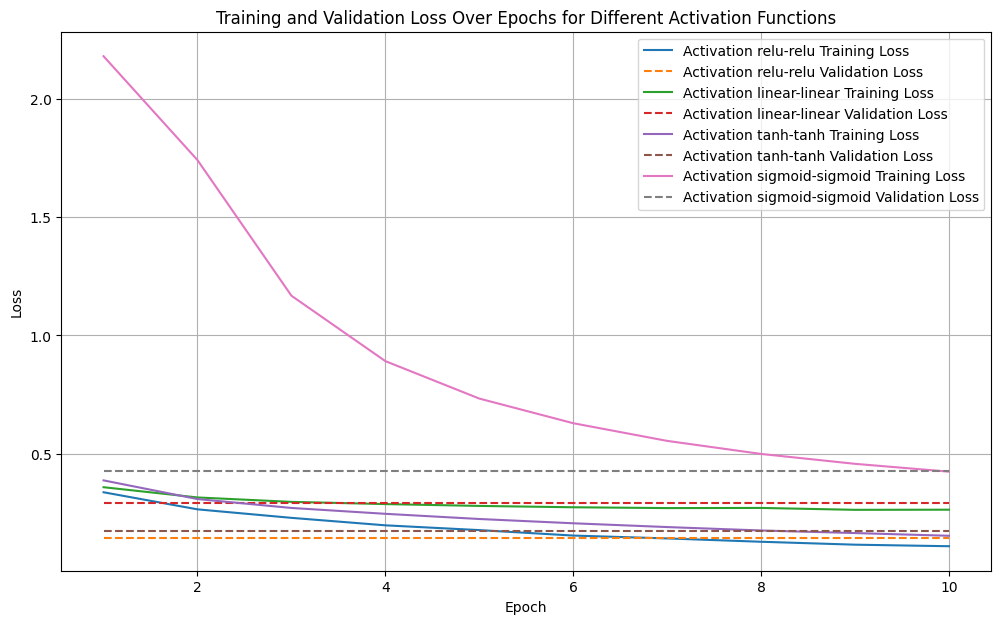


Validation Accuracies:
Activation relu-relu: 0.9591
Activation linear-linear: 0.9204
Activation tanh-tanh: 0.9506
Activation sigmoid-sigmoid: 0.8849


In [30]:
# Plotting the loss history for different activation functions
plt.figure(figsize=(12, 7))
for activation_label, train_history in training_loss_history_per_activations.items():
    val_history = validation_loss_history_per_activations[activation_label]
    epochs = range(1, len(train_history) + 1)
    plt.plot(epochs, train_history, label=f'{activation_label} Training Loss')
    plt.plot(epochs, val_history, label=f'{activation_label} Validation Loss', linestyle='--')

plt.title('Training and Validation Loss Over Epochs for Different Activation Functions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Validation accuracy per activation combo
print("\nValidation Accuracies:")
for activation_label, accuracy in results.items():
    print(f"{activation_label}: {accuracy:.4f}")


In [ ]:
# # Plot Histogram Distribusi Bobot dan Gradien Bobot
# plt.figure(figsize=(12, 5))
# for i, activation in enumerate(activation_functions):
#     weights = model.get_weights()  # Ambil bobot dari model
#     gradients = model.get_gradients()  # Ambil gradien dari model

#     plt.subplot(2, len(activation_functions), i+1)
#     plt.hist(weights, bins=50, alpha=0.7, color='blue', label='Weights')
#     plt.title(f'Weights: {activation[0]}')

#     plt.subplot(2, len(activation_functions), i+len(activation_functions)+1)
#     plt.hist(gradients, bins=50, alpha=0.7, color='red', label='Gradients')
#     plt.title(f'Gradients: {activation[0]}')

# plt.tight_layout()
# plt.show()

In [32]:
# Learning Rate Variations
learning_rates = [0.0001, 0.001, 0.01]
results = {}
training_loss_history_per_lr = {}
validation_loss_history_per_lr = {}

In [33]:
epochs = 10
layer_sizes = [784, 64, 64, 10]
activations = ['relu', 'relu', 'softmax']

for lr in learning_rates:
    model = CustomFFNN(
        layer_sizes=layer_sizes,
        activations=activations,
        loss='cce',
        weight_method='normal'
    )
    
    label = f"LR {lr}"
    print(f"\nTraining model with {label}")

    training_losses = model.fit(X_train, y_train_encoded, epochs=epochs, learning_rate=lr, batch_size=32)
    validation_losses = []

    for ep in range(1, epochs + 1):
        start_time = time.time()
        y_val_pred_encoded = model.predict(X_val)
        
        val_loss = LossFunction.cce(y_val_encoded, y_val_pred_encoded)
        validation_losses.append(val_loss)

        print(f"Epoch {ep}, Training Loss: {training_losses[ep-1]:.4f}, Validation Loss: {val_loss:.4f}, Time: {time.time()-start_time:.2f}s")

    y_pred_encoded = model.predict(X_val)
    y_pred = np.argmax(y_pred_encoded, axis=1)
    y_val_true = np.argmax(y_val_encoded, axis=1)
    acc = accuracy_score(y_val_true, y_pred)

    results[label] = acc
    training_loss_history_per_lr[label] = training_losses
    validation_loss_history_per_lr[label] = validation_losses

    print(f"\nValidation Accuracy ({label}): {acc:.4f}")
    model.save_to_txt(f"learning_rate_variations_{label}")
    



Training model with LR 0.0001



Epoch 1, Loss: 2.2602, Time: 1.45s



Epoch 2, Loss: 2.1843, Time: 1.44s



Epoch 3, Loss: 2.1119, Time: 1.46s



Epoch 4, Loss: 2.0371, Time: 1.46s



Epoch 5, Loss: 1.9572, Time: 1.45s



Epoch 6, Loss: 1.8713, Time: 1.43s



Epoch 7, Loss: 1.7800, Time: 1.47s



Epoch 8, Loss: 1.6846, Time: 1.54s



Epoch 9, Loss: 1.5871, Time: 1.48s



Epoch 10, Loss: 1.4899, Time: 1.50s
Epoch 1, Training Loss: 2.2602, Validation Loss: 1.4911, Time: 0.04s
Epoch 2, Training Loss: 2.1843, Validation Loss: 1.4911, Time: 0.04s
Epoch 3, Training Loss: 2.1119, Validation Loss: 1.4911, Time: 0.04s
Epoch 4, Training Loss: 2.0371, Validation Loss: 1.4911, Time: 0.04s
Epoch 5, Training Loss: 1.9572, Validation Loss: 1.4911, Time: 0.04s
Epoch 6, Training Loss: 1.8713, Validation Loss: 1.4911, Time: 0.04s
Epoch 7, Training Loss: 1.7800, Validation Loss: 1.4911, Time: 0.04s
Epoch 8, Training Loss: 1.6846, Validation Loss: 1.4911, Time: 0.04s
Epoch 9, Training Loss: 1.5871, Validation Loss: 1.4911, Time: 0.04s
Epoch 10, Training Loss: 1.4899, Validation Loss: 1.4911, Time: 0.04s

Validation Accuracy (LR 0.0001): 0.6736

Training model with LR 0.001



Epoch 1, Loss: 1.4409, Time: 1.72s



Epoch 2, Loss: 0.8218, Time: 1.49s



Epoch 3, Loss: 0.5961, Time: 1.46s



Epoch 4, Loss: 0.4955, Time: 1.51s



Epoch 5, Loss: 0.4399, Time: 1.49s



Epoch 6, Loss: 0.4047, Time: 1.46s



Epoch 7, Loss: 0.3808, Time: 1.43s



Epoch 8, Loss: 0.3626, Time: 1.46s



Epoch 9, Loss: 0.3481, Time: 1.52s



Epoch 10, Loss: 0.3359, Time: 1.46s
Epoch 1, Training Loss: 1.4409, Validation Loss: 0.3417, Time: 0.03s
Epoch 2, Training Loss: 0.8218, Validation Loss: 0.3417, Time: 0.03s
Epoch 3, Training Loss: 0.5961, Validation Loss: 0.3417, Time: 0.04s
Epoch 4, Training Loss: 0.4955, Validation Loss: 0.3417, Time: 0.03s
Epoch 5, Training Loss: 0.4399, Validation Loss: 0.3417, Time: 0.04s
Epoch 6, Training Loss: 0.4047, Validation Loss: 0.3417, Time: 0.03s
Epoch 7, Training Loss: 0.3808, Validation Loss: 0.3417, Time: 0.04s
Epoch 8, Training Loss: 0.3626, Validation Loss: 0.3417, Time: 0.04s
Epoch 9, Training Loss: 0.3481, Validation Loss: 0.3417, Time: 0.04s
Epoch 10, Training Loss: 0.3359, Validation Loss: 0.3417, Time: 0.04s

Validation Accuracy (LR 0.001): 0.9039

Training model with LR 0.01



Epoch 1, Loss: 0.3419, Time: 1.50s



Epoch 2, Loss: 0.2713, Time: 1.43s



Epoch 3, Loss: 0.2307, Time: 1.46s



Epoch 4, Loss: 0.2090, Time: 1.46s



Epoch 5, Loss: 0.1852, Time: 1.44s



Epoch 6, Loss: 0.1716, Time: 1.46s



Epoch 7, Loss: 0.1610, Time: 1.44s



Epoch 8, Loss: 0.1391, Time: 1.50s



Epoch 9, Loss: 0.1304, Time: 1.44s



Epoch 10, Loss: 0.1193, Time: 1.43s
Epoch 1, Training Loss: 0.3419, Validation Loss: 0.1508, Time: 0.03s
Epoch 2, Training Loss: 0.2713, Validation Loss: 0.1508, Time: 0.04s
Epoch 3, Training Loss: 0.2307, Validation Loss: 0.1508, Time: 0.04s
Epoch 4, Training Loss: 0.2090, Validation Loss: 0.1508, Time: 0.04s
Epoch 5, Training Loss: 0.1852, Validation Loss: 0.1508, Time: 0.04s
Epoch 6, Training Loss: 0.1716, Validation Loss: 0.1508, Time: 0.04s
Epoch 7, Training Loss: 0.1610, Validation Loss: 0.1508, Time: 0.04s
Epoch 8, Training Loss: 0.1391, Validation Loss: 0.1508, Time: 0.04s
Epoch 9, Training Loss: 0.1304, Validation Loss: 0.1508, Time: 0.04s
Epoch 10, Training Loss: 0.1193, Validation Loss: 0.1508, Time: 0.04s

Validation Accuracy (LR 0.01): 0.9577


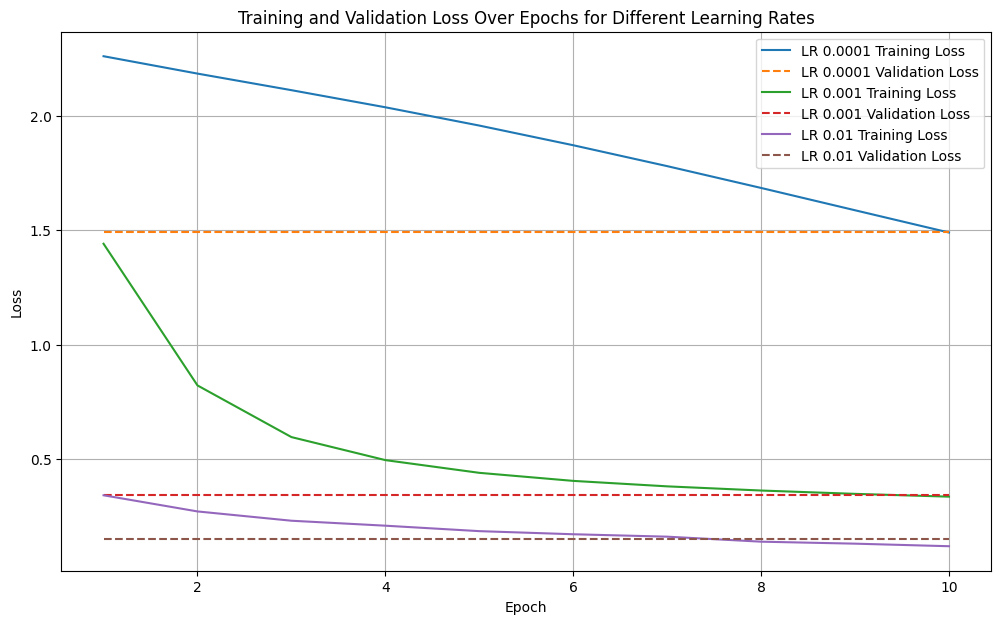


Validation Accuracies:
LR 0.0001: 0.6736
LR 0.001: 0.9039
LR 0.01: 0.9577


In [35]:
# Plotting the loss history for different learning rates
plt.figure(figsize=(12, 7))
for lr_label, train_history in training_loss_history_per_lr.items():
    val_history = validation_loss_history_per_lr[lr_label]
    epochs = range(1, len(train_history) + 1)
    plt.plot(epochs, train_history, label=f'{lr_label} Training Loss')
    plt.plot(epochs, val_history, label=f'{lr_label} Validation Loss', linestyle='--')

plt.title('Training and Validation Loss Over Epochs for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nValidation Accuracies:")
for lr_label, accuracy in results.items():
    print(f"{lr_label}: {accuracy:.4f}")


In [ ]:
# # Plot Histogram Distribusi Bobot dan Gradien Bobot
# plt.figure(figsize=(12, 5))
# for i, learning_rate in enumerate(learning_rates):
#     weights = model.get_weights()  # Ambil bobot dari model
#     gradients = model.get_gradients()  # Ambil gradien dari model

#     plt.subplot(2, len(learning_rates), i+1)
#     plt.hist(weights, bins=50, alpha=0.7, color='blue', label='Weights')
#     plt.title(f'Weights: learning rate {learning_rate}')

#     plt.subplot(2, len(learning_rates), i+len(learning_rates)+1)
#     plt.hist(gradients, bins=50, alpha=0.7, color='red', label='Gradients')
#     plt.title(f'Gradients: learning rate{learning_rate}')

# plt.tight_layout()
# plt.show()

In [37]:
# Variasi metode inisialisasi bobot
weight_init_methods = ['zero', 'uniform', 'normal']

# Tempat simpan hasil
results_weight_init = {}
train_loss_history_per_init = {}
val_loss_history_per_init = {}


In [38]:
epochs = 10
for init_method in weight_init_methods:
    print(f"\nTraining with weight initialization: {init_method}")
    
    model = CustomFFNN(
        layer_sizes=[784, 128, 64, 10],
        activations=['relu', 'relu', 'softmax'],
        loss='cce',
        weight_method=init_method
    )
    
    training_losses = model.fit(X_train, y_train_encoded, epochs=epochs, learning_rate=0.01, batch_size=32)
    
    validation_losses = []
    for ep in range(1, epochs + 1):
        y_val_pred_encoded = model.predict(X_val)
        val_loss = LossFunction.cce(y_val_encoded, y_val_pred_encoded)
        validation_losses.append(val_loss)
        
        print(f"Epoch {ep}, Training Loss: {training_losses[ep-1]:.4f}, Validation Loss: {val_loss:.4f}")
    
    y_pred_encoded = model.predict(X_val)
    y_pred = np.argmax(y_pred_encoded, axis=1)
    y_val_true = np.argmax(y_val_encoded, axis=1)
    acc = accuracy_score(y_val_true, y_pred)

    results_weight_init[init_method] = acc
    train_loss_history_per_init[init_method] = training_losses
    val_loss_history_per_init[init_method] = validation_losses

    print(f"Validation Accuracy (Init: {init_method}): {acc:.4f}")
    model.save_to_txt(f"init_method_variations_{init_method}")
    



Training with weight initialization: zero



Epoch 1, Loss: 2.3013, Time: 2.08s



Epoch 2, Loss: 2.3012, Time: 2.01s



Epoch 3, Loss: 2.3012, Time: 2.53s



Epoch 4, Loss: 2.3012, Time: 2.05s



Epoch 5, Loss: 2.3012, Time: 2.06s



Epoch 6, Loss: 2.3012, Time: 2.02s



Epoch 7, Loss: 2.3012, Time: 2.00s



Epoch 8, Loss: 2.3012, Time: 2.03s



Epoch 9, Loss: 2.3012, Time: 1.99s



Epoch 10, Loss: 2.3012, Time: 1.99s
Epoch 1, Training Loss: 2.3013, Validation Loss: 2.3009
Epoch 2, Training Loss: 2.3012, Validation Loss: 2.3009
Epoch 3, Training Loss: 2.3012, Validation Loss: 2.3009
Epoch 4, Training Loss: 2.3012, Validation Loss: 2.3009
Epoch 5, Training Loss: 2.3012, Validation Loss: 2.3009
Epoch 6, Training Loss: 2.3012, Validation Loss: 2.3009
Epoch 7, Training Loss: 2.3012, Validation Loss: 2.3009
Epoch 8, Training Loss: 2.3012, Validation Loss: 2.3009
Epoch 9, Training Loss: 2.3012, Validation Loss: 2.3009
Epoch 10, Training Loss: 2.3012, Validation Loss: 2.3009
Validation Accuracy (Init: zero): 0.1143

Training with weight initialization: uniform



Epoch 1, Loss: 0.4568, Time: 2.06s



Epoch 2, Loss: 0.3375, Time: 2.05s



Epoch 3, Loss: 0.2883, Time: 2.06s



Epoch 4, Loss: 0.2638, Time: 2.05s



Epoch 5, Loss: 0.2337, Time: 2.14s



Epoch 6, Loss: 0.2121, Time: 2.02s



Epoch 7, Loss: 0.1920, Time: 2.06s



Epoch 8, Loss: 0.1803, Time: 2.29s



Epoch 9, Loss: 0.1691, Time: 2.11s



Epoch 10, Loss: 0.1587, Time: 2.11s
Epoch 1, Training Loss: 0.4568, Validation Loss: 0.1894
Epoch 2, Training Loss: 0.3375, Validation Loss: 0.1894
Epoch 3, Training Loss: 0.2883, Validation Loss: 0.1894
Epoch 4, Training Loss: 0.2638, Validation Loss: 0.1894
Epoch 5, Training Loss: 0.2337, Validation Loss: 0.1894
Epoch 6, Training Loss: 0.2121, Validation Loss: 0.1894
Epoch 7, Training Loss: 0.1920, Validation Loss: 0.1894
Epoch 8, Training Loss: 0.1803, Validation Loss: 0.1894
Epoch 9, Training Loss: 0.1691, Validation Loss: 0.1894
Epoch 10, Training Loss: 0.1587, Validation Loss: 0.1894
Validation Accuracy (Init: uniform): 0.9453

Training with weight initialization: normal



Epoch 1, Loss: 0.3386, Time: 2.04s



Epoch 2, Loss: 0.2720, Time: 2.08s



Epoch 3, Loss: 0.2352, Time: 2.08s



Epoch 4, Loss: 0.2014, Time: 2.11s



Epoch 5, Loss: 0.1795, Time: 2.08s



Epoch 6, Loss: 0.1634, Time: 2.09s



Epoch 7, Loss: 0.1529, Time: 2.10s



Epoch 8, Loss: 0.1434, Time: 2.09s



Epoch 9, Loss: 0.1245, Time: 2.18s



Epoch 10, Loss: 0.1263, Time: 2.10s
Epoch 1, Training Loss: 0.3386, Validation Loss: 0.1598
Epoch 2, Training Loss: 0.2720, Validation Loss: 0.1598
Epoch 3, Training Loss: 0.2352, Validation Loss: 0.1598
Epoch 4, Training Loss: 0.2014, Validation Loss: 0.1598
Epoch 5, Training Loss: 0.1795, Validation Loss: 0.1598
Epoch 6, Training Loss: 0.1634, Validation Loss: 0.1598
Epoch 7, Training Loss: 0.1529, Validation Loss: 0.1598
Epoch 8, Training Loss: 0.1434, Validation Loss: 0.1598
Epoch 9, Training Loss: 0.1245, Validation Loss: 0.1598
Epoch 10, Training Loss: 0.1263, Validation Loss: 0.1598
Validation Accuracy (Init: normal): 0.9535


In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 7))
for init_label in train_loss_history_per_init:
    epochs_range = range(1, len(train_loss_history_per_init[init_label]) + 1)
    plt.plot(epochs_range, train_loss_history_per_init[init_label], label=f'{init_label} Train Loss')
    plt.plot(epochs_range, val_loss_history_per_init[init_label], linestyle='--', label=f'{init_label} Val Loss')

plt.title('Training and Validation Loss Over Epochs for Weight Initialization Methods')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nFinal Validation Accuracies (per weight init):")
for init_label, acc in results_weight_init.items():
    print(f"{init_label}: {acc:.4f}")


In [ ]:
# # Plot Histogram Distribusi Bobot dan Gradien Bobot
# plt.figure(figsize=(12, 5))
# for i, bobot in enumerate(method_init_bobot):
#     weights = model.get_weights()  # Ambil bobot dari model
#     gradients = model.get_gradients()  # Ambil gradien dari model

#     plt.subplot(2, len(method_init_bobot), i+1)
#     plt.hist(weights, bins=50, alpha=0.7, color='blue', label='Weights')
#     plt.title(f'Weights: bobot {bobot}')

#     plt.subplot(2, len(method_init_bobot), i+len(method_init_bobot)+1)
#     plt.hist(gradients, bins=50, alpha=0.7, color='red', label='Gradients')
#     plt.title(f'Gradients: Bobot {bobot}')

# plt.tight_layout()
# plt.show()

In [39]:
# Variasi metode inisialisasi bobot
reguralizations = ['L1', 'L2']

# Tempat simpan hasil
results_weight_r = {}
train_loss_history_per_r = {}
val_loss_history_per_r = {}


In [40]:
epochs = 10
for reg in reguralizations:
    print(f"\nTraining with Regularization: {reg}")
    
    model = CustomFFNN(
        layer_sizes=[784, 128, 64, 10],
        activations=['relu', 'relu', 'softmax'],
        loss='cce',
        weight_method="normal",
        regularization = reg
    )
    
    training_losses = model.fit(X_train, y_train_encoded, epochs=epochs, learning_rate=0.01, batch_size=32)
    
    validation_losses = []
    for ep in range(1, epochs + 1):
        y_val_pred_encoded = model.predict(X_val)
        val_loss = LossFunction.cce(y_val_encoded, y_val_pred_encoded)
        validation_losses.append(val_loss)
        
        print(f"Epoch {ep}, Training Loss: {training_losses[ep-1]:.4f}, Validation Loss: {val_loss:.4f}")
    
    y_pred_encoded = model.predict(X_val)
    y_pred = np.argmax(y_pred_encoded, axis=1)
    y_val_true = np.argmax(y_val_encoded, axis=1)
    acc = accuracy_score(y_val_true, y_pred)

    results_weight_r[reg] = acc
    train_loss_history_per_r[reg] = training_losses
    val_loss_history_per_r[reg] = validation_losses

    print(f"Validation Accuracy (Regularization: {reg}): {acc:.4f}")
    model.save_to_txt(f"regularization_variations_{reg}")
    



Training with Regularization: L1



Epoch 1, Loss: 0.3404, Reg Loss: 44.8826, Total: 45.2230, Time: 3.87s



Epoch 2, Loss: 0.2781, Reg Loss: 40.2485, Total: 40.5266, Time: 4.26s



Epoch 3, Loss: 0.2445, Reg Loss: 36.0163, Total: 36.2608, Time: 3.88s



Epoch 4, Loss: 0.2225, Reg Loss: 32.2079, Total: 32.4304, Time: 3.83s



Epoch 5, Loss: 0.2018, Reg Loss: 28.8348, Total: 29.0366, Time: 3.91s



Epoch 6, Loss: 0.1909, Reg Loss: 25.8651, Total: 26.0560, Time: 3.85s



Epoch 7, Loss: 0.1865, Reg Loss: 23.2585, Total: 23.4450, Time: 3.97s



Epoch 8, Loss: 0.1770, Reg Loss: 20.9889, Total: 21.1659, Time: 3.88s



Epoch 9, Loss: 0.1679, Reg Loss: 19.0370, Total: 19.2049, Time: 3.87s



Epoch 10, Loss: 0.1617, Reg Loss: 17.3417, Total: 17.5034, Time: 4.05s
Epoch 1, Training Loss: 45.2230, Validation Loss: 0.1808
Epoch 2, Training Loss: 40.5266, Validation Loss: 0.1808
Epoch 3, Training Loss: 36.2608, Validation Loss: 0.1808
Epoch 4, Training Loss: 32.4304, Validation Loss: 0.1808
Epoch 5, Training Loss: 29.0366, Validation Loss: 0.1808
Epoch 6, Training Loss: 26.0560, Validation Loss: 0.1808
Epoch 7, Training Loss: 23.4450, Validation Loss: 0.1808
Epoch 8, Training Loss: 21.1659, Validation Loss: 0.1808
Epoch 9, Training Loss: 19.2049, Validation Loss: 0.1808
Epoch 10, Training Loss: 17.5034, Validation Loss: 0.1808
Validation Accuracy (Regularization: L1): 0.9491

Training with Regularization: L2



Epoch 1, Loss: 0.3433, Reg Loss: 4.1394, Total: 4.4827, Time: 2.66s



Epoch 2, Loss: 0.2684, Reg Loss: 4.1512, Total: 4.4196, Time: 2.68s



Epoch 3, Loss: 0.2346, Reg Loss: 4.1429, Total: 4.3775, Time: 2.78s



Epoch 4, Loss: 0.1976, Reg Loss: 4.1318, Total: 4.3294, Time: 2.63s



Epoch 5, Loss: 0.1779, Reg Loss: 4.1174, Total: 4.2953, Time: 2.65s



Epoch 6, Loss: 0.1580, Reg Loss: 4.0999, Total: 4.2579, Time: 2.70s



Epoch 7, Loss: 0.1460, Reg Loss: 4.0816, Total: 4.2276, Time: 2.67s



Epoch 8, Loss: 0.1384, Reg Loss: 4.0612, Total: 4.1996, Time: 2.64s



Epoch 9, Loss: 0.1386, Reg Loss: 4.0393, Total: 4.1779, Time: 2.74s



Epoch 10, Loss: 0.1154, Reg Loss: 4.0185, Total: 4.1339, Time: 2.68s
Epoch 1, Training Loss: 4.4827, Validation Loss: 0.1447
Epoch 2, Training Loss: 4.4196, Validation Loss: 0.1447
Epoch 3, Training Loss: 4.3775, Validation Loss: 0.1447
Epoch 4, Training Loss: 4.3294, Validation Loss: 0.1447
Epoch 5, Training Loss: 4.2953, Validation Loss: 0.1447
Epoch 6, Training Loss: 4.2579, Validation Loss: 0.1447
Epoch 7, Training Loss: 4.2276, Validation Loss: 0.1447
Epoch 8, Training Loss: 4.1996, Validation Loss: 0.1447
Epoch 9, Training Loss: 4.1779, Validation Loss: 0.1447
Epoch 10, Training Loss: 4.1339, Validation Loss: 0.1447
Validation Accuracy (Regularization: L2): 0.9591


In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 7))
for reg in train_loss_history_per_r:
    epochs_range = range(1, len(train_loss_history_per_r[reg]) + 1)
    plt.plot(epochs_range, train_loss_history_per_r[reg], label=f'{reg} Train Loss')
    plt.plot(epochs_range, val_loss_history_per_r[reg], linestyle='--', label=f'{reg} Val Loss')

plt.title('Training and Validation Loss Over Epochs for Regularizations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nFinal Validation Accuracies (per Regularizations):")
for reg, acc in results_weight_r.items():
    print(f"{reg}: {acc:.4f}")


In [ ]:
model = CustomFFNN(
        layer_sizes=[784, 128, 64, 10],
        activations=['relu', 'relu', 'softmax'],
        loss='cce',
        weight_method="normal",
        regularization = reg
    )
    
training_losses = model.fit(X_train, y_train_encoded, epochs=epochs, learning_rate=0.01, batch_size=32)

validation_losses = []
for ep in range(1, epochs + 1):
    y_val_pred_encoded = model.predict(X_val)
    val_loss = LossFunction.cce(y_val_encoded, y_val_pred_encoded)
    validation_losses.append(val_loss)
    
    print(f"Epoch {ep}, Training Loss: {training_losses[ep-1]:.4f}, Validation Loss: {val_loss:.4f}")

y_pred_encoded = model.predict(X_val)
y_pred = np.argmax(y_pred_encoded, axis=1)
y_val_true = np.argmax(y_val_encoded, axis=1)
acc = accuracy_score(y_val_true, y_pred)

results_weight_r[reg] = acc
train_loss_history_per_r[reg] = training_losses
val_loss_history_per_r[reg] = validation_losses

print(f"Validation Accuracy (Regularization: {reg}): {acc:.4f}")

In [ ]:
# Compare with Sklearn MLPClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Label untuk sklearn harus dalam bentuk class, bukan one-hot
y_train_class = np.argmax(y_train_encoded, axis=1)
y_val_class = np.argmax(y_val_encoded, axis=1)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',               
    learning_rate_init=0.01,         
    max_iter=epochs,                 
    batch_size=32,
    verbose = True
)

mlp.fit(X_train, y_train_class)

# Evaluasi di validation set
y_pred_mlp = mlp.predict(X_val)
acc_mlp = accuracy_score(y_val_class, y_pred_mlp)

results_weight_r['sklearn_MLP'] = acc_mlp

print(f"Validation Accuracy (sklearn MLPClassifier): {acc_mlp:.4f}")
print(f"Validation Accuracy (Custom FFNN): {acc:.4f}")
